In [1]:
from __future__ import print_function
import argparse
import sys
import os
import itertools
import random
import time
import numpy as np
import shutil
import gc
import re
import keras
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras import optimizers 
from keras import backend as K
import tensorflow as tf
from PIL import Image
from IPython.display import display
from PIL import Image
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# make or reset directory
def mk_reset_dir(directory):
    if os.path.exists(directory):
        try:
            shutil.rmtree(directory)
            os.mkdir(directory)
        except:
            print("error:", directory)
    else:
        try:
            os.mkdir(directory)
        except:
            print("error create:", directory)
            

In [4]:
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [6]:
# setting data path data seperated by class name
training_dir = r"/content/drive/MyDrive/Dataset(Train, Test, Valid)/DS/train"
testing_dir = r"/content/drive/MyDrive/Dataset(Train, Test, Valid)/DS/test"
validation_dir = r'/content/drive/MyDrive/Dataset(Train, Test, Valid)/DS/valid'

# # setting output directory
# model_dir = r"data/output/models/"
# log_dir = r"data/output/logs"

In [7]:
# Set number of class
num_class = len(os.listdir(training_dir))

# setting training parameters
norm = 255.0
rescale=1./norm
shear_range=0.2
zoom_range=0.2
horizontal_flip=True

# setting train, test, validation parameters
target_size=(224, 224)
# batch_size=32
batch_size=64
class_mode='categorical'

loss='categorical_crossentropy'
# metrics=['accuracy', 'binary_accuracy', precision, recall]
metrics=['accuracy']

epochs = 40
verbose = 2 # trying  2 instead of !

In [ ]:
# model_file = model_dir+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
# # model_file = "weights-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"
# model_file

NameError: ignored

In [8]:
# data generator for training
train_datagen = ImageDataGenerator(
        rescale=rescale,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for validation
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for testing
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

Found 548 images belonging to 4 classes.
Found 129 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

In [13]:
# importing inception model
base_model = InceptionV3(weights='imagenet', include_top=False)

# setting model layers specially output layer with class number
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

#loading model
model = Model(inputs=base_model.input, outputs=predictions)


#print layers of inception model
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
    
    
# set all laeyrs as untrainable
for layer in base_model.layers:
    layer.trainable = False
    
# train the top inception layers 
# freeze first 249 layers
# unfreeze the rest
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
    
# set optimizer
# sgd = optimizers.Adam()
# sgd = optimizers.Adam(lr=0.001)
# sgd = optimizers.Adam(lr=0.0001)
# sgd = optimizers.SGD()
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# sgd = optimizer=SGD(lr=0.0001, momentum=0.9)

# compile model with optimizer and loss
model.compile(optimizer=adam(lr=0.0004), loss=loss, metrics=metrics)

NameError: ignored

In [11]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [ ]:
# checkpoint = keras.callbacks.ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)
# # early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)
# # early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

# # tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=1, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
# tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
# # tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, batch_size=32, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

# tensorboard.set_model(model) 


# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)

# # callbacks_list = [checkpoint, tensorboard, early_stopping]
# # callbacks_list = [reduce_lr, checkpoint, tensorboard, early_stopping]
# callbacks_list = [reduce_lr, checkpoint, tensorboard]

NameError: ignored

In [12]:
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch = len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    )

Epoch 1/40
9/9 [==============================] - 244s 26s/step - loss: 1.3872 - accuracy: 0.4015 - val_loss: 1.4524 - val_accuracy: 0.2636
Epoch 2/40
9/9 [==============================] - 111s 12s/step - loss: 0.9414 - accuracy: 0.6004 - val_loss: 1.5950 - val_accuracy: 0.3411
Epoch 3/40
9/9 [==============================] - 111s 13s/step - loss: 0.7402 - accuracy: 0.7007 - val_loss: 2.1196 - val_accuracy: 0.2946
Epoch 4/40
9/9 [==============================] - 111s 13s/step - loss: 0.6769 - accuracy: 0.7263 - val_loss: 1.9689 - val_accuracy: 0.3333
Epoch 5/40
9/9 [==============================] - 111s 13s/step - loss: 0.6567 - accuracy: 0.7555 - val_loss: 2.2050 - val_accuracy: 0.3333
Epoch 6/40
9/9 [==============================] - 111s 12s/step - loss: 0.6040 - accuracy: 0.7682 - val_loss: 2.4353 - val_accuracy: 0.4419
Epoch 7/40
9/9 [==============================] - 111s 12s/step - loss: 0.5582 - accuracy: 0.7646 - val_loss: 2.7110 - val_accuracy: 0.3333
Epoch 8/40
9/9 [====

In [20]:
test_labels = test_generator.classes

In [21]:
predictions = model.predict(x=test_generator, steps=len(test_generator), verbose=0)

In [22]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
test_generator.class_indices

{'Abnormal': 0, 'History': 1, 'Mi': 2, 'Normal': 3}

Confusion matrix, without normalization
[[5 0 0 0]
 [5 0 0 0]
 [4 0 1 0]
 [5 0 0 0]]


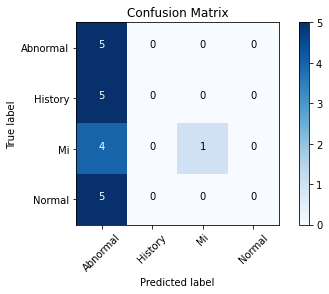

In [25]:
cm_plot_labels = ['Abnormal', 'History', 'Mi', 'Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=(224,224),
        batch_size=5,
        class_mode='categorical',
        shuffle=False)

class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())


nb_validation_samples = 129
batch_size = 5
#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

#print('Confusion Matrix')
#print(confusion_matrix(test_generator.classes, y_pred))
print("\n\n")
print('Classification Report\n')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


Found 20 images belonging to 4 classes.



Classification Report

              precision    recall  f1-score   support

    Abnormal       0.26      1.00      0.42         5
     History       0.00      0.00      0.00         5
          Mi       1.00      0.20      0.33         5
      Normal       0.00      0.00      0.00         5

    accuracy                           0.30        20
   macro avg       0.32      0.30      0.19        20
weighted avg       0.32      0.30      0.19        20



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


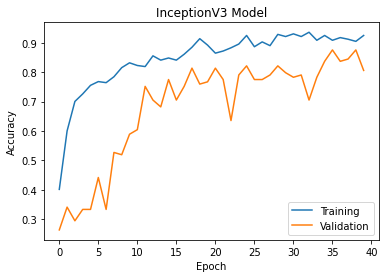

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('InceptionV3 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

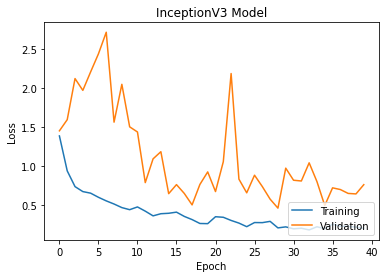

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

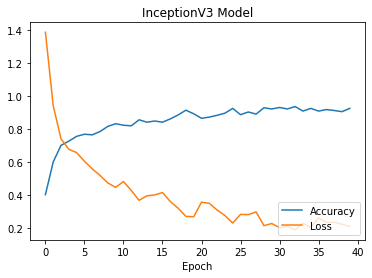

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('InceptionV3 Model')
plt.ylabel('')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='lower right')
plt.show()

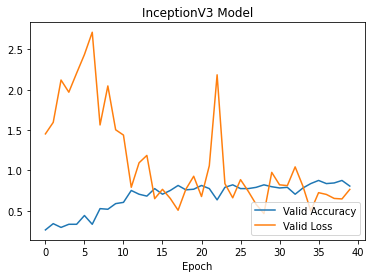

In [39]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Model')
plt.ylabel('')
plt.xlabel('Epoch')
plt.legend(['Valid Accuracy', 'Valid Loss'], loc='lower right')
plt.show()

In [40]:
model.save('ECGInceptionV3.model')

INFO:tensorflow:Assets written to: ECGInceptionV3.model/assets


In [42]:
def prepare_image(file):
    img_path = '/content/drive/MyDrive/Dataset(Train, Test, Valid)/DS/Apply/'
    img = image.load_img(img_path + file, target_size=(200, 200, 3))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

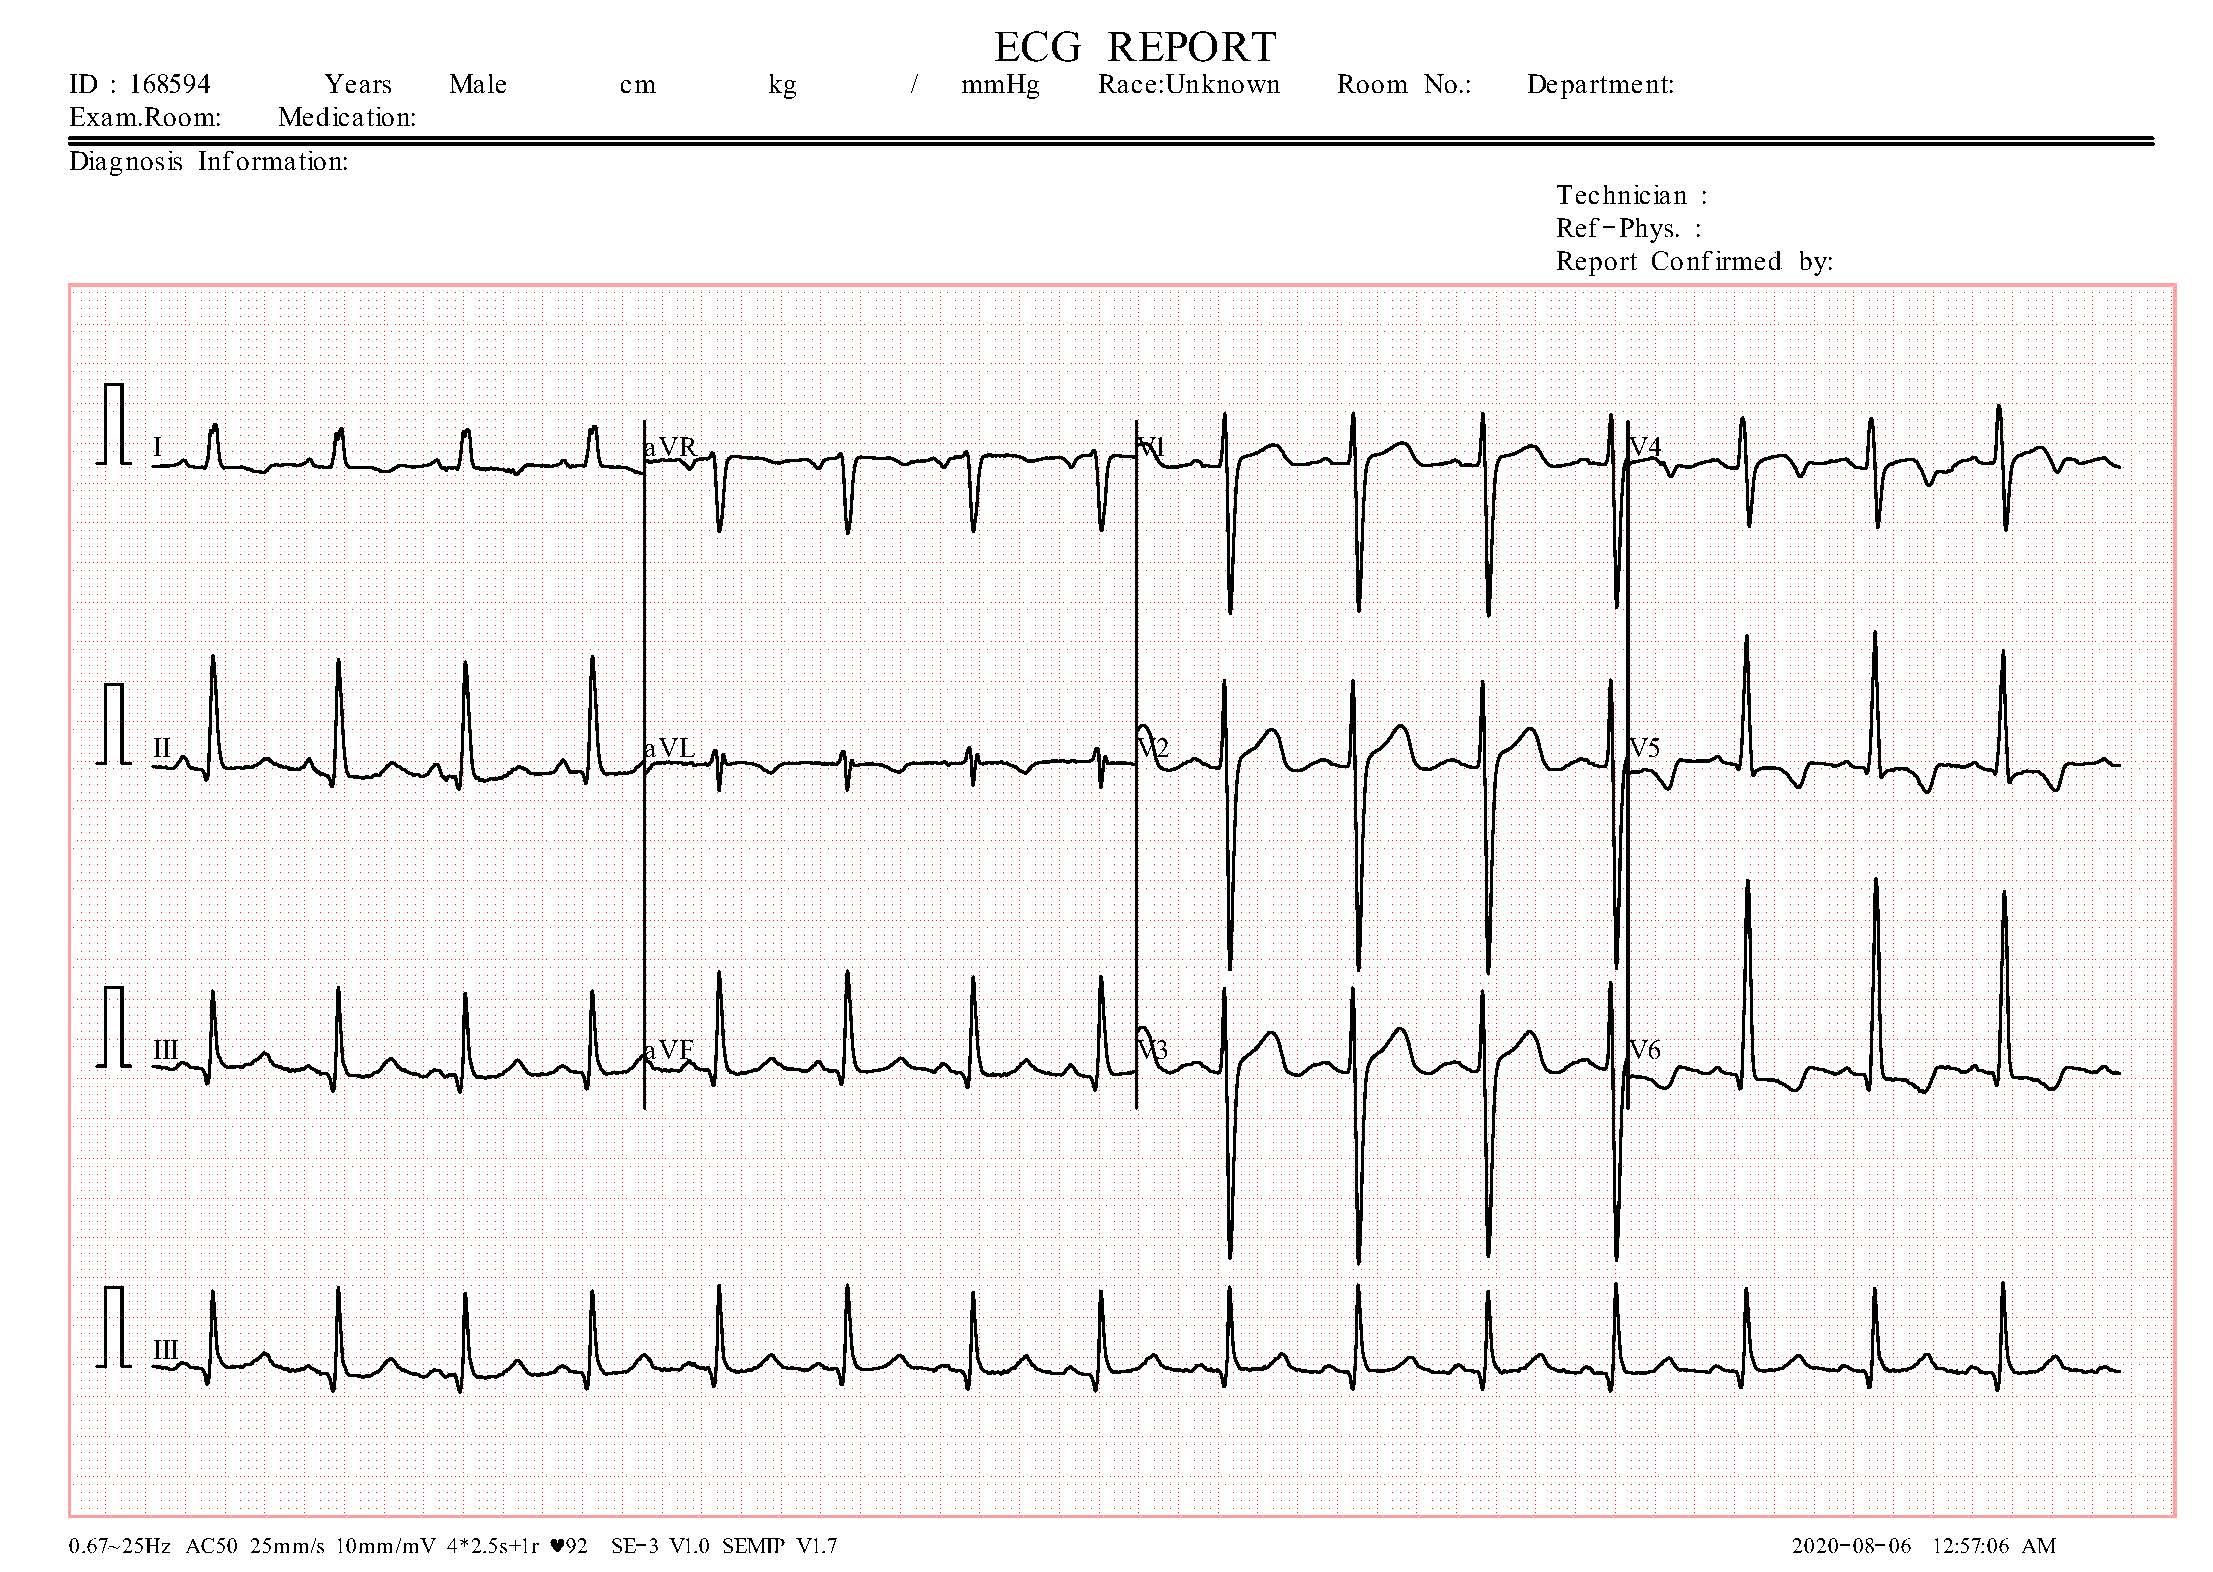

In [43]:
Image(filename='/content/drive/MyDrive/Dataset(Train, Test, Valid)/DS/Apply/abnormal(1).jpg', width=500, height=500) 

In [44]:
cm_plot_labels = ['Abnormal', 'History', 'Mi', 'Normal']
import numpy as np 
preprocessed_image = prepare_image('abnormal(1).jpg')
model = tf.keras.models.load_model("ECGInceptionV3.model")
predictions = model.predict(preprocessed_image)
arr = np.array(predictions)
print(arr)
max_index_row = np.argmax(arr, axis=1)
#print(max_index_row[0])
print("Probability")
print(arr[0, max_index_row]*100)
cm_plot_labels[max_index_row[0]]

[[0.41748816 0.08514587 0.26343095 0.23393494]]
Probability
[41.748817]


'Abnormal'

In [45]:
cm_plot_labels = ['Abnormal', 'History', 'Mi', 'Normal']
import numpy as np 
preprocessed_image = prepare_image('history(1).jpg')
model = tf.keras.models.load_model("ECGInceptionV3.model")
predictions = model.predict(preprocessed_image)
arr = np.array(predictions)
print(arr)
max_index_row = np.argmax(arr, axis=1)
#print(max_index_row[0])
print("Probability")
print(arr[0, max_index_row]*100)
cm_plot_labels[max_index_row[0]]

[[0.556339   0.08922487 0.1816615  0.17277467]]
Probability
[55.633904]


'Abnormal'